#Análisis NLP de tweets




---


##Extracción de datos

In [ ]:
import tweepy
import pandas as pd
import json

In [ ]:
#Credenciales de autenticación para la API de tweeter

with open('auth.json') as f:
  authData = json.load(f)

consumerkey = authData["consumerKey"]
consumerSecret = authData["consumerSecret"]
accessToken = authData["accessToken"]
accessTokenSecret = authData["accessTokenSecret"]

In [ ]:
#Crear el objeto de autenticacion
auth = tweepy.OAuthHandler(consumerkey, consumerSecret)

#Establecer los accessToken
auth.set_access_token(accessToken, accessTokenSecret)

#Crear el objeto API con la info de autenticación
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
keywords = "presidente petro" #Palabras clave para buscar tweets 
limit = 2000

tweets = tweepy.Cursor(api.search, q=f'{keywords} -filter:retweets', lang='es' ,count=100, tweet_mode='extended', retweeted_status='full_text').items(limit)
df = pd.DataFrame([tweet.full_text for tweet in tweets], columns=['tweet'])
df

,tweet
0,Uno en twitter conoce gente y personas muy bac...
1,Los berracos de @NoticiasCaracol #NoticiasCara...
2,@MiguelUribeT Sinico descarado solo les gusta ...
3,@Punkecit0 @ElVendedor9 Así a pasado en la his...
4,"@MiguelUribeT Así es toche,para q sigan lloran..."
...,...
1995,@petrogustavo Señor Petro recuerde que usted y...
1996,@dorlax @jackiediazreyes @ELTIEMPO @Uinvestiga...
1997,"Señor Presidente Gustavo Petro, necesitamos un..."
1998,"@MartinaVlez_ @MiguelPoloP Pobre loca, te ref..."


---
##Limpieza de datos

In [ ]:
from unicodedata import normalize
import re

def removeAccents(text):
  return re.sub(
      r'([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+', r'\1', # Elimina acentos sin cambiar la 'ñ' por 'n'
      normalize('NFD', text), 0, re.I
      )

def cleanText(text):
  text = re.sub(r'@\S+', '', text) # Eliminacion de @Menciones
  text = re.sub(r'#\S+', '', text) # Eliminacion de #Hashtags
  text  = re.sub(r'https?:\/\/\S+', '', text) # Eliminacion de links
  text = re.sub(r'[^\w\s]', '', text) # Eliminacion de simbolos (emojis, signos de puntuacion, caracteres especiales)
  text = re.sub("\d+", ' ', text)  # Eliminación de números
  text = text.lower() # Pasar todo a minuscula
  text = removeAccents(text)

  return text

df['cleaned_tweet'] = df['tweet'].apply(cleanText)
df[['cleaned_tweet']]

,cleaned_tweet
0,uno en twitter conoce gente y personas muy bac...
1,los berracos de entrevistan a don arturo cal...
2,sinico descarado solo les gusta la reeleccion...
3,asi a pasado en la historia d colombiacon pe...
4,asi es tochepara q sigan llorando soy gustav...
...,...
1995,señor petro recuerde que usted ya es el pres...
1996,pablo escobar fue jefe del narco president...
1997,señor presidente gustavo petro necesitamos un...
1998,pobre loca te refieres al que dijo que petr...


---
##Tokenización


In [ ]:
import nltk
nltk.download('punkt')

def tokenize(text):
  tokens = nltk.word_tokenize(text)
  tokens = [token.lower() for token in tokens if len(token) > 1] # Eliminación de tokens con una longitud < 2
  return tokens

df['tokenized_tweet'] = df['cleaned_tweet'].apply(tokenize)
df[['tokenized_tweet']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,tokenized_tweet
0,"[uno, en, twitter, conoce, gente, personas, mu..."
1,"[los, berracos, de, entrevistan, don, arturo, ..."
2,"[sinico, descarado, solo, les, gusta, la, reel..."
3,"[asi, pasado, en, la, historia, colombiacon, p..."
4,"[asi, es, tochepara, sigan, llorando, soy, gus..."
...,...
1995,"[señor, petro, recuerde, que, usted, ya, es, ..."
1996,"[pablo, escobar, fue, jefe, del, narco, presid..."
1997,"[señor, presidente, gustavo, petro, necesitam..."
1998,"[pobre, loca, te, refieres, al, que, dijo, que..."


---
##Eliminar stop-words


In [ ]:
nltk.download('stopwords')

# Las stopwords vienen con acentos y los tokens estan sin acentos, asi que es necesario eliminar acentos de las stopwords
stopWords = [removeAccents(word) for word in nltk.corpus.stopwords.words('spanish')]
stopWords.extend(['gustavo', 'petro', 'presidente'])

def removeStopWords(tokenizedText):
  return [word for word in tokenizedText if word not in stopWords]

df['non_stopwords_tweet'] = df['tokenized_tweet'].apply(removeStopWords)
df[['non_stopwords_tweet']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,non_stopwords_tweet
0,"[twitter, conoce, gente, personas, bacanas, ac..."
1,"[berracos, entrevistan, don, arturo, calle, ha..."
2,"[sinico, descarado, solo, gusta, reeleccion, f..."
3,"[asi, pasado, historia, colombiacon, va, haber..."
4,"[asi, tochepara, sigan, llorando]"
...,...
1995,"[señor, recuerde, usted, colombia, momento, d..."
1996,"[pablo, escobar, jefe, narco, indultado]"
1997,"[señor, necesitamos, ministro, deporte, haga,..."
1998,"[pobre, loca, refieres, dijo, nunca, ahora, de..."


---
##Stemming
Utilizando algoritmo de Snowball: https://snowballstem.org/


In [ ]:
from nltk import SnowballStemmer

stemmer = SnowballStemmer('spanish')

def stemming(tokenizedText):
  return [stemmer.stem(word) for word in tokenizedText]

df['stemmed_tweet'] = df['non_stopwords_tweet'].apply(stemming)
df[['stemmed_tweet']]

,stemmed_tweet
0,"[twitt, conoc, gent, person, bacan, aca, ayer,..."
1,"[berrac, entrevist, don, artur, call, habl, ma..."
2,"[sinic, descar, sol, gust, reeleccion, favor, ..."
3,"[asi, pas, histori, colombiacon, va, hab, cambi]"
4,"[asi, tochep, sig, llor]"
...,...
1995,"[señor, recuerd, usted, colombi, moment, dej,..."
1996,"[pabl, escob, jef, narc, indult]"
1997,"[señor, necesit, ministr, deport, hag, cambi,..."
1998,"[pobr, loc, refier, dij, nunc, ahor, deb, llam..."


---
##Lematización


In [ ]:
!python -m spacy download es_core_news_sm

In [ ]:
import spacy
nlp = spacy.load('es_core_news_sm')

def lemmatization(tokenizedText):
  lemmas = [word.lemma_ for word in nlp(' '.join(tokenizedText))]
  return list(set(lemmas))

df['lemmatized_tweet'] = df['non_stopwords_tweet'].apply(lemmatization).apply(removeStopWords)
df[['lemmatized_tweet']]

,lemmatized_tweet
0,"[gana, bacana, acar, conocer, ayer, productivo..."
1,"[arturo, berraco, idea, calle, mismo, mal, emp..."
2,"[sinico, reeleccion, gustar, hacer, tiempo, pu..."
3,"[historia, cambio, pasado, haber, ir, colombia..."
4,"[llorar, seguir, asi, tochepar]"
...,...
1995,"[comenzar, trabajar, poner, gobierno, espeer, ..."
1996,"[jefe, escobar, narco, indultado, pablo]"
1997,"[peticion, ministro, cambio, señor, necesitar..."
1998,"[retrasado, refier, ahora, señor, decir, debe..."


---
##Análisis de Sentimientos
Utilizando libreria PySentimiento: https://github.com/pysentimiento/pysentimiento


In [ ]:
!pip install pysentimiento

from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")

In [ ]:
def analyzeSentiments(words):
  return analyzer.predict(' '.join(words))

df['sentiment_analysis'] = df['lemmatized_tweet'].apply(analyzeSentiments)

df['type'] = df['sentiment_analysis'].apply(lambda x: x.output)
df['probability_pos'] = df['sentiment_analysis'].apply(lambda x: x.probas['POS'])
df['probability_neg'] = df['sentiment_analysis'].apply(lambda x: x.probas['NEG'])
df['probability_neu'] = df['sentiment_analysis'].apply(lambda x: x.probas['NEU'])
df['sentiment_analysis']

0       AnalyzerOutput(output=NEU, probas={NEU: 0.561,...
1       AnalyzerOutput(output=NEG, probas={NEG: 0.997,...
2       AnalyzerOutput(output=NEG, probas={NEG: 0.933,...
3       AnalyzerOutput(output=NEU, probas={NEU: 0.942,...
4       AnalyzerOutput(output=NEG, probas={NEG: 0.738,...
                              ...                        
1995    AnalyzerOutput(output=NEU, probas={NEU: 0.859,...
1996    AnalyzerOutput(output=NEG, probas={NEG: 0.499,...
1997    AnalyzerOutput(output=NEU, probas={NEU: 0.930,...
1998    AnalyzerOutput(output=NEG, probas={NEG: 0.964,...
1999    AnalyzerOutput(output=NEU, probas={NEU: 0.823,...
Name: sentiment_analysis, Length: 2000, dtype: object

---
##Estadística Descriptiva

In [ ]:
print("\nProbabilidad media de ser tweet positivo: " , df['probability_pos'].mean())
print("Probabilidad media de ser tweet negativo: " , df['probability_neg'].mean())
print("Probabilidad media de ser tweet neutro: " , df['probability_neu'].mean())

print("\n\nVarianza en la probabilidad de ser tweet positivo: " , df['probability_pos'].var())
print("Varianza en la probabilidad de ser tweet negativo: " , df['probability_neg'].var())
print("Varianza en la probabilidad de ser tweet neutro: " , df['probability_neu'].var())

print("\n\nDesviación estándar de la probabilidad de ser tweet positivo: " , df['probability_pos'].std())
print("Desviación estándar de la probabilidad de ser tweet negativo: " , df['probability_neg'].std())
print("Desviación estándar de la probabilidad de ser tweet neutro: " , df['probability_neu'].std())


Probabilidad media de ser tweet positivo:  0.03724026665114798
Probabilidad media de ser tweet negativo:  0.46694978346550486
Probabilidad media de ser tweet neutro:  0.49580995158624136


Varianza en la probabilidad de ser tweet positivo:  0.017618796727283156
Varianza en la probabilidad de ser tweet negativo:  0.18019346373944814
Varianza en la probabilidad de ser tweet neutro:  0.16955156248151174


Desviación estándar de la probabilidad de ser tweet positivo:  0.13273581554080705
Desviación estándar de la probabilidad de ser tweet negativo:  0.42449200668498827
Desviación estándar de la probabilidad de ser tweet neutro:  0.41176639309384117


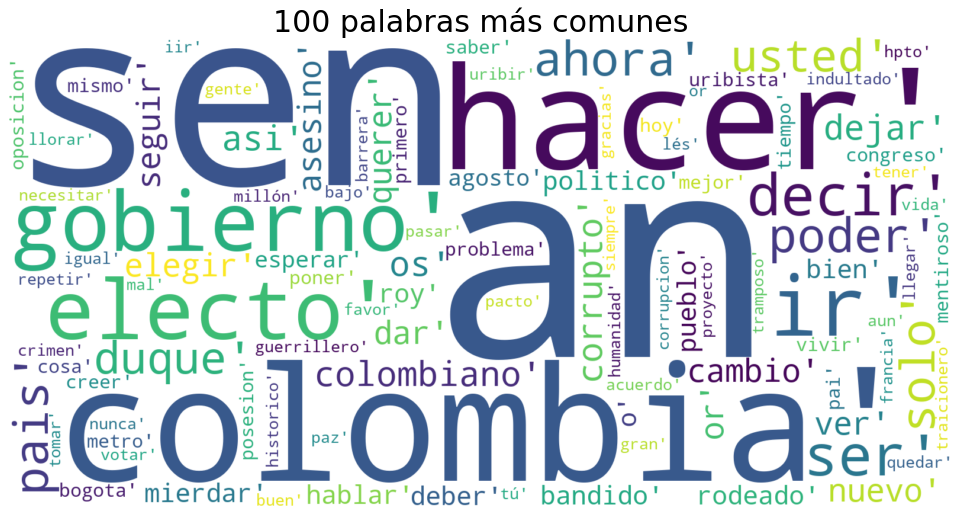

In [ ]:
from nltk import FreqDist
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

allwords =[]

for word in df['lemmatized_tweet']:
  allwords += word


mostCommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white', stopwords=set(stopWords)).generate(str(mostCommon))
fig = plt.figure(figsize=(21,7), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('100 palabras más comunes', fontsize=30)
plt.tight_layout(pad=0)
plt.show()

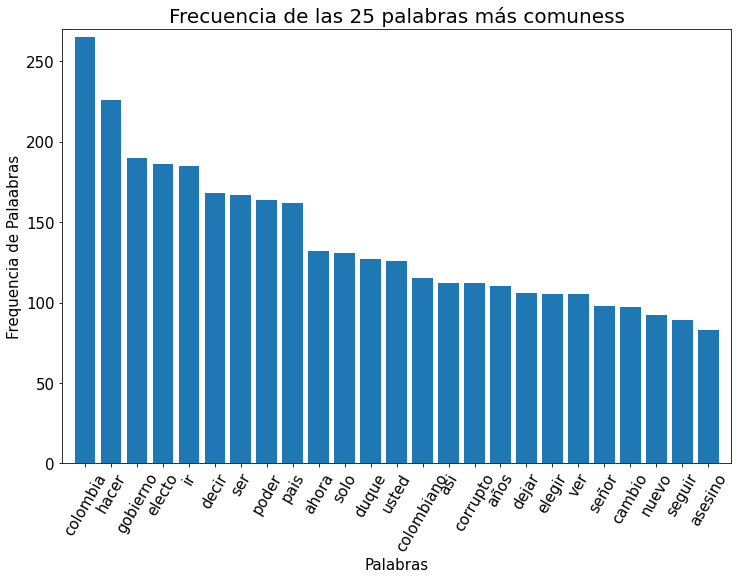

In [ ]:
mostCommon= FreqDist(allwords).most_common(25)
x, y = zip(*mostCommon)

plt.figure(figsize=(12,8))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Palabras', fontsize=15)
plt.ylabel('Frequencia de Palaabras', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=60, fontsize=15)
plt.title('Frecuencia de las 25 palabras más comuness', fontsize=20)
plt.show()

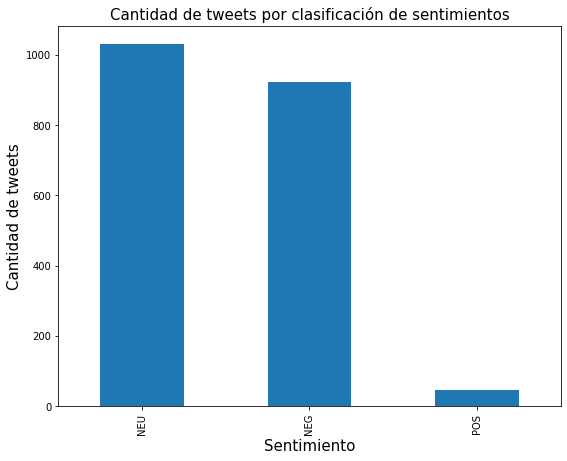

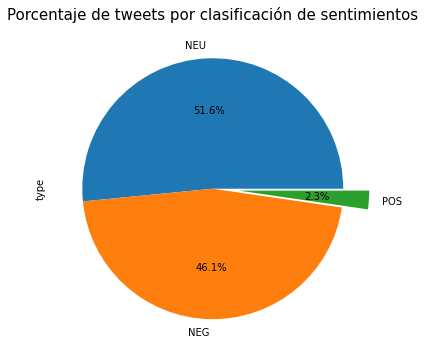

In [ ]:
df['type'].value_counts().plot(kind='bar', figsize=(9,7))
plt.xlabel('Sentimiento', fontsize=15)
plt.ylabel('Cantidad de tweets', fontsize=15)
plt.title('Cantidad de tweets por clasificación de sentimientos', fontsize=15)
plt.show()

df['type'].value_counts().plot.pie(figsize=(8, 6), explode = (0,0,0.2), autopct='%1.1f%%')
plt.title('Porcentaje de tweets por clasificación de sentimientos', fontsize=15)
plt.show()

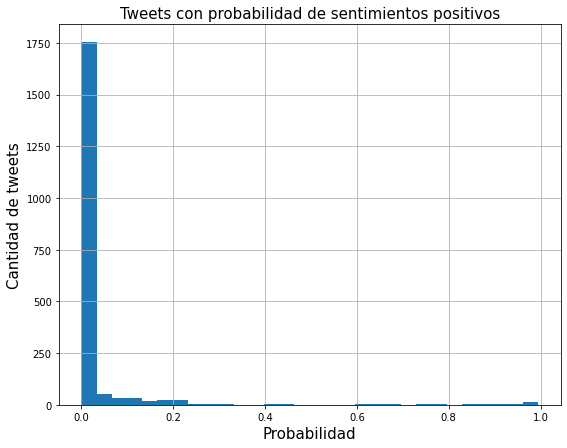

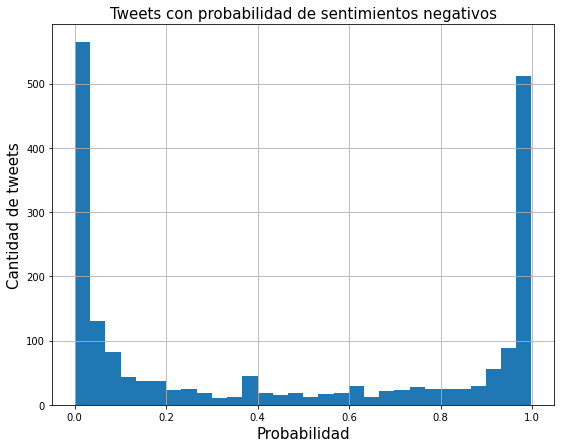

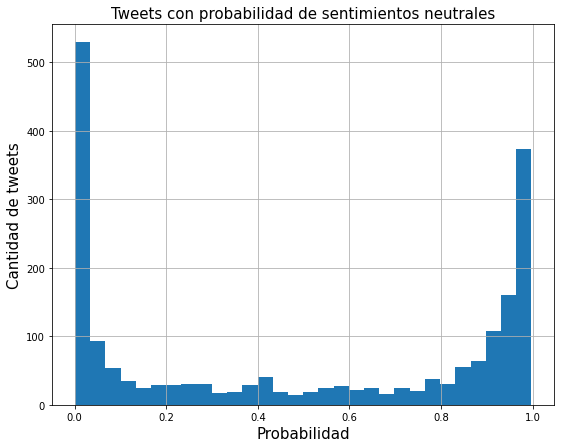

In [ ]:
df['probability_pos'].hist(bins=30, figsize=(9, 7))
plt.xlabel('Probabilidad', fontsize=15)
plt.ylabel('Cantidad de tweets', fontsize=15)
plt.title('Tweets con probabilidad de sentimientos positivos', fontsize=15)
plt.show()

df['probability_neg'].hist(bins=30, figsize=(9, 7))
plt.xlabel('Probabilidad', fontsize=15)
plt.ylabel('Cantidad de tweets', fontsize=15)
plt.title('Tweets con probabilidad de sentimientos negativos', fontsize=15)
plt.show()

df['probability_neu'].hist(bins=30, figsize=(9, 7))
plt.xlabel('Probabilidad', fontsize=15)
plt.ylabel('Cantidad de tweets', fontsize=15)
plt.title('Tweets con probabilidad de sentimientos neutrales', fontsize=15)
plt.show()

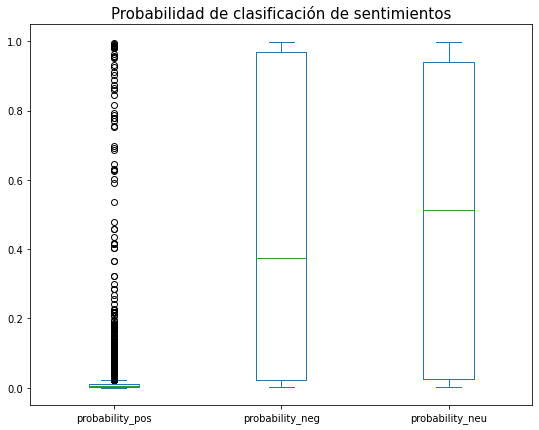

In [ ]:
df[['probability_pos', 'probability_neg', 'probability_neu']].plot.box(figsize=(9, 7))
plt.title('Probabilidad de clasificación de sentimientos', fontsize=15)
plt.show()

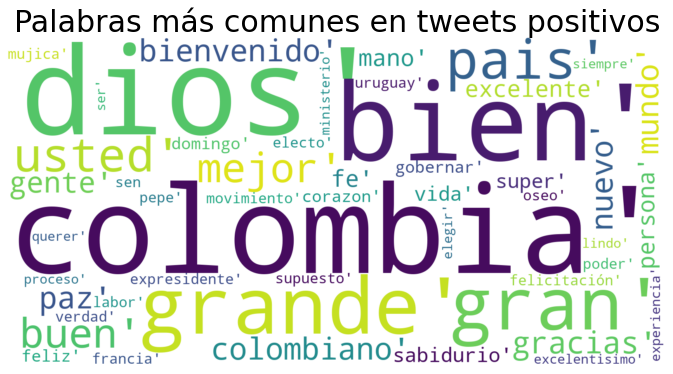

In [ ]:
pos_words =[]

for word in df.query("type == 'POS'")['lemmatized_tweet']:
  pos_words += word

mostCommon = FreqDist(pos_words).most_common(50)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostCommon))
fig = plt.figure(figsize=(13,5), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Palabras más comunes en tweets positivos', fontsize=30)
plt.tight_layout(pad=0)
plt.show()

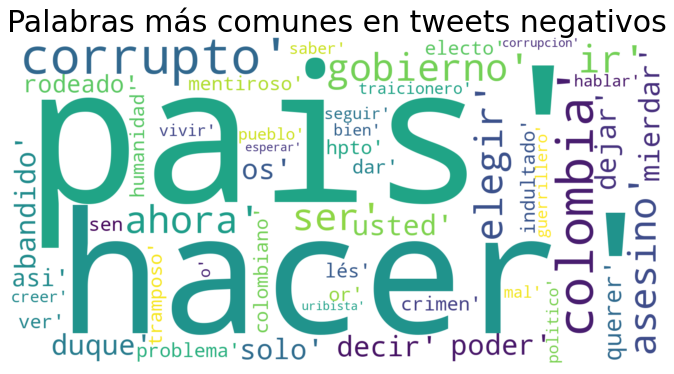

In [ ]:
neg_words =[]

for word in df.query("type == 'NEG'")['lemmatized_tweet']:
  neg_words += word

mostCommon = FreqDist(neg_words).most_common(50)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostCommon))
fig = plt.figure(figsize=(13,5), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Palabras más comunes en tweets negativos', fontsize=30)
plt.tight_layout(pad=0)
plt.show()

##Análisis de Emociones

In [ ]:
emotion_analyzer = create_analyzer(task="emotion", lang="es")

In [ ]:
def analyzeEmotions(words):
  return emotion_analyzer.predict(' '.join(words)).output

df_pos_and_neg = df.query("type != 'NEU'")[['lemmatized_tweet', 'type']]
df_pos_and_neg['emotion'] = df_pos_and_neg['lemmatized_tweet'].apply(analyzeEmotions)

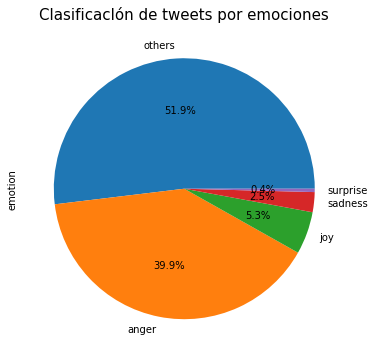

In [ ]:
df_pos_and_neg['emotion'].value_counts().plot.pie(figsize=(8, 6), autopct='%1.1f%%')
plt.title('ClasificacIón de tweets por emociones', fontsize=15)
plt.show()

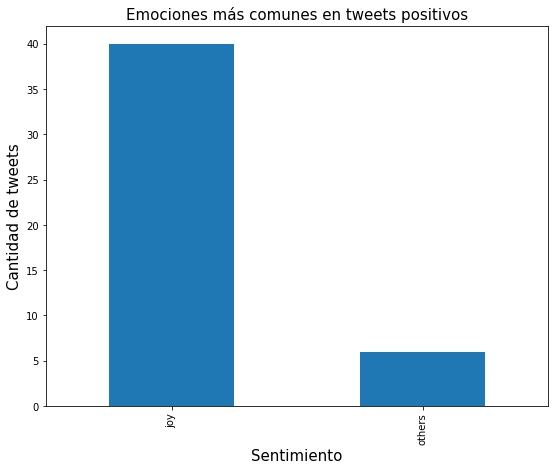

In [ ]:
df_pos_and_neg.query("type == 'POS'")['emotion'].value_counts().plot(kind='bar', figsize=(9,7))
plt.xlabel('Sentimiento', fontsize=15)
plt.ylabel('Cantidad de tweets', fontsize=15)
plt.title('Emociones más comunes en tweets positivos', fontsize=15)
plt.show()

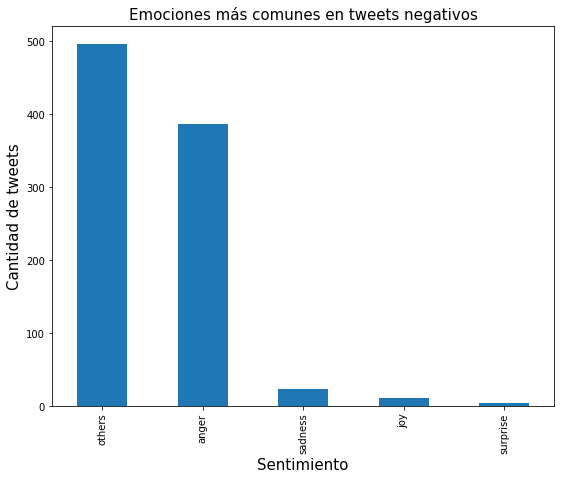

In [ ]:
df_pos_and_neg.query("type == 'NEG'")['emotion'].value_counts().plot(kind='bar', figsize=(9,7))
plt.xlabel('Sentimiento', fontsize=15)
plt.ylabel('Cantidad de tweets', fontsize=15)
plt.title('Emociones más comunes en tweets negativos', fontsize=15)
plt.show()